# MELI challenge!

In [260]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np

path = 'precios_historicos.csv'
data = pd.read_csv(path)

In [261]:
data.head()

,ITEM_ID,ORD_CLOSED_DT,PRICE
0,MLB4432316952,2024-02-15,22.0100
1,MLB4432316952,2024-03-02,19.8090
2,MLB4432316952,2024-02-16,22.0100
3,MLB4432316952,2024-03-08,23.8134
4,MLB4432316952,2024-02-22,19.0990


In [262]:
# number of  unique products
len(data["ITEM_ID"].unique())

300

Primero, me gustaría saber algunos detalles importantes sobre los datos...

- ¿Cómo son las distribuciones de precios a lo largo del tiempo?
- ¿Qué tan equilibrado es el número de entradas para cada producto? Por ejemplo, si un producto tiene precios registrados durante 1000 días, ¿los otros productos tienen un número similar de entradas?

Para simplificar y acelerar el desarrollo, en esta primera iteración haremos una comparación entre dos métodos para obtener anomalías:

# Propuesta de solucion:

Probaremos detectar las anomalías usando:

- **Z-Score**
  - **Descripción**: El Z-Score mide cuántas desviaciones estándar un elemento está del promedio de un conjunto de datos. En la detección de anomalías, un Z-Score alto indica que el dato es altamente inusual comparado con el conjunto normal.
  - **Aplicación**: Utilizaremos el Z-Score para identificar valores que sean significativamente más altos o más bajos que la media, considerando valores con un Z-Score absoluto mayor que 3 como anómalos.

- **Percentiles**
  - **Descripción**: Los percentiles dividen el conjunto de datos en 100 partes iguales, permitiendo evaluar si un valor se encuentra dentro de los extremos del conjunto.
  - **Aplicación**: Calcularemos el 1% y el 99% percentiles para identificar los precios que son extremadamente bajos o altos en comparación con el histórico. Los precios fuera de estos rangos serán considerados anomalías.


In [268]:
df = data.copy()
df['ORD_CLOSED_DT'] = pd.to_datetime(df['ORD_CLOSED_DT'])
df['z_score'] = pd.Series(dtype=float)
df['is_anomaly_percentile'] = pd.Series(dtype=bool)

for item_id, group in df.groupby('ITEM_ID'):
    group['z_score'] = zscore(group['PRICE'])
    df.loc[group.index, 'z_score'] = group['z_score']

    lower_bound = group['PRICE'].quantile(0.01)
    upper_bound = group['PRICE'].quantile(0.99)
    
    group_anomalies = (group['PRICE'] < lower_bound) | (group['PRICE'] > upper_bound)
    df.loc[group.index, 'is_anomaly_percentile'] = group_anomalies

df['is_anomaly_z'] = abs(df['z_score']) > 3

df.head()


,ITEM_ID,ORD_CLOSED_DT,PRICE,is_anomaly_percentile,z_score,is_anomaly_z
0,MLB4432316952,2024-02-15,22.0100,False,-0.519530,False
1,MLB4432316952,2024-03-02,19.8090,False,-0.642482,False
2,MLB4432316952,2024-02-16,22.0100,False,-0.519530,False
3,MLB4432316952,2024-03-08,23.8134,False,-0.418789,False
4,MLB4432316952,2024-02-22,19.0990,False,-0.682144,False


/var/folders/j5/ypdvjx255895xx7q7g52zkbw0000gp/T/ipykernel_89475/448162189.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['ORD_CLOSED_DT'] = pd.to_datetime(sample_df['ORD_CLOSED_DT'])
/var/folders/j5/ypdvjx255895xx7q7g52zkbw0000gp/T/ipykernel_89475/448162189.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.sort_values(['ITEM_ID', 'ORD_CLOSED_DT'], inplace=True)


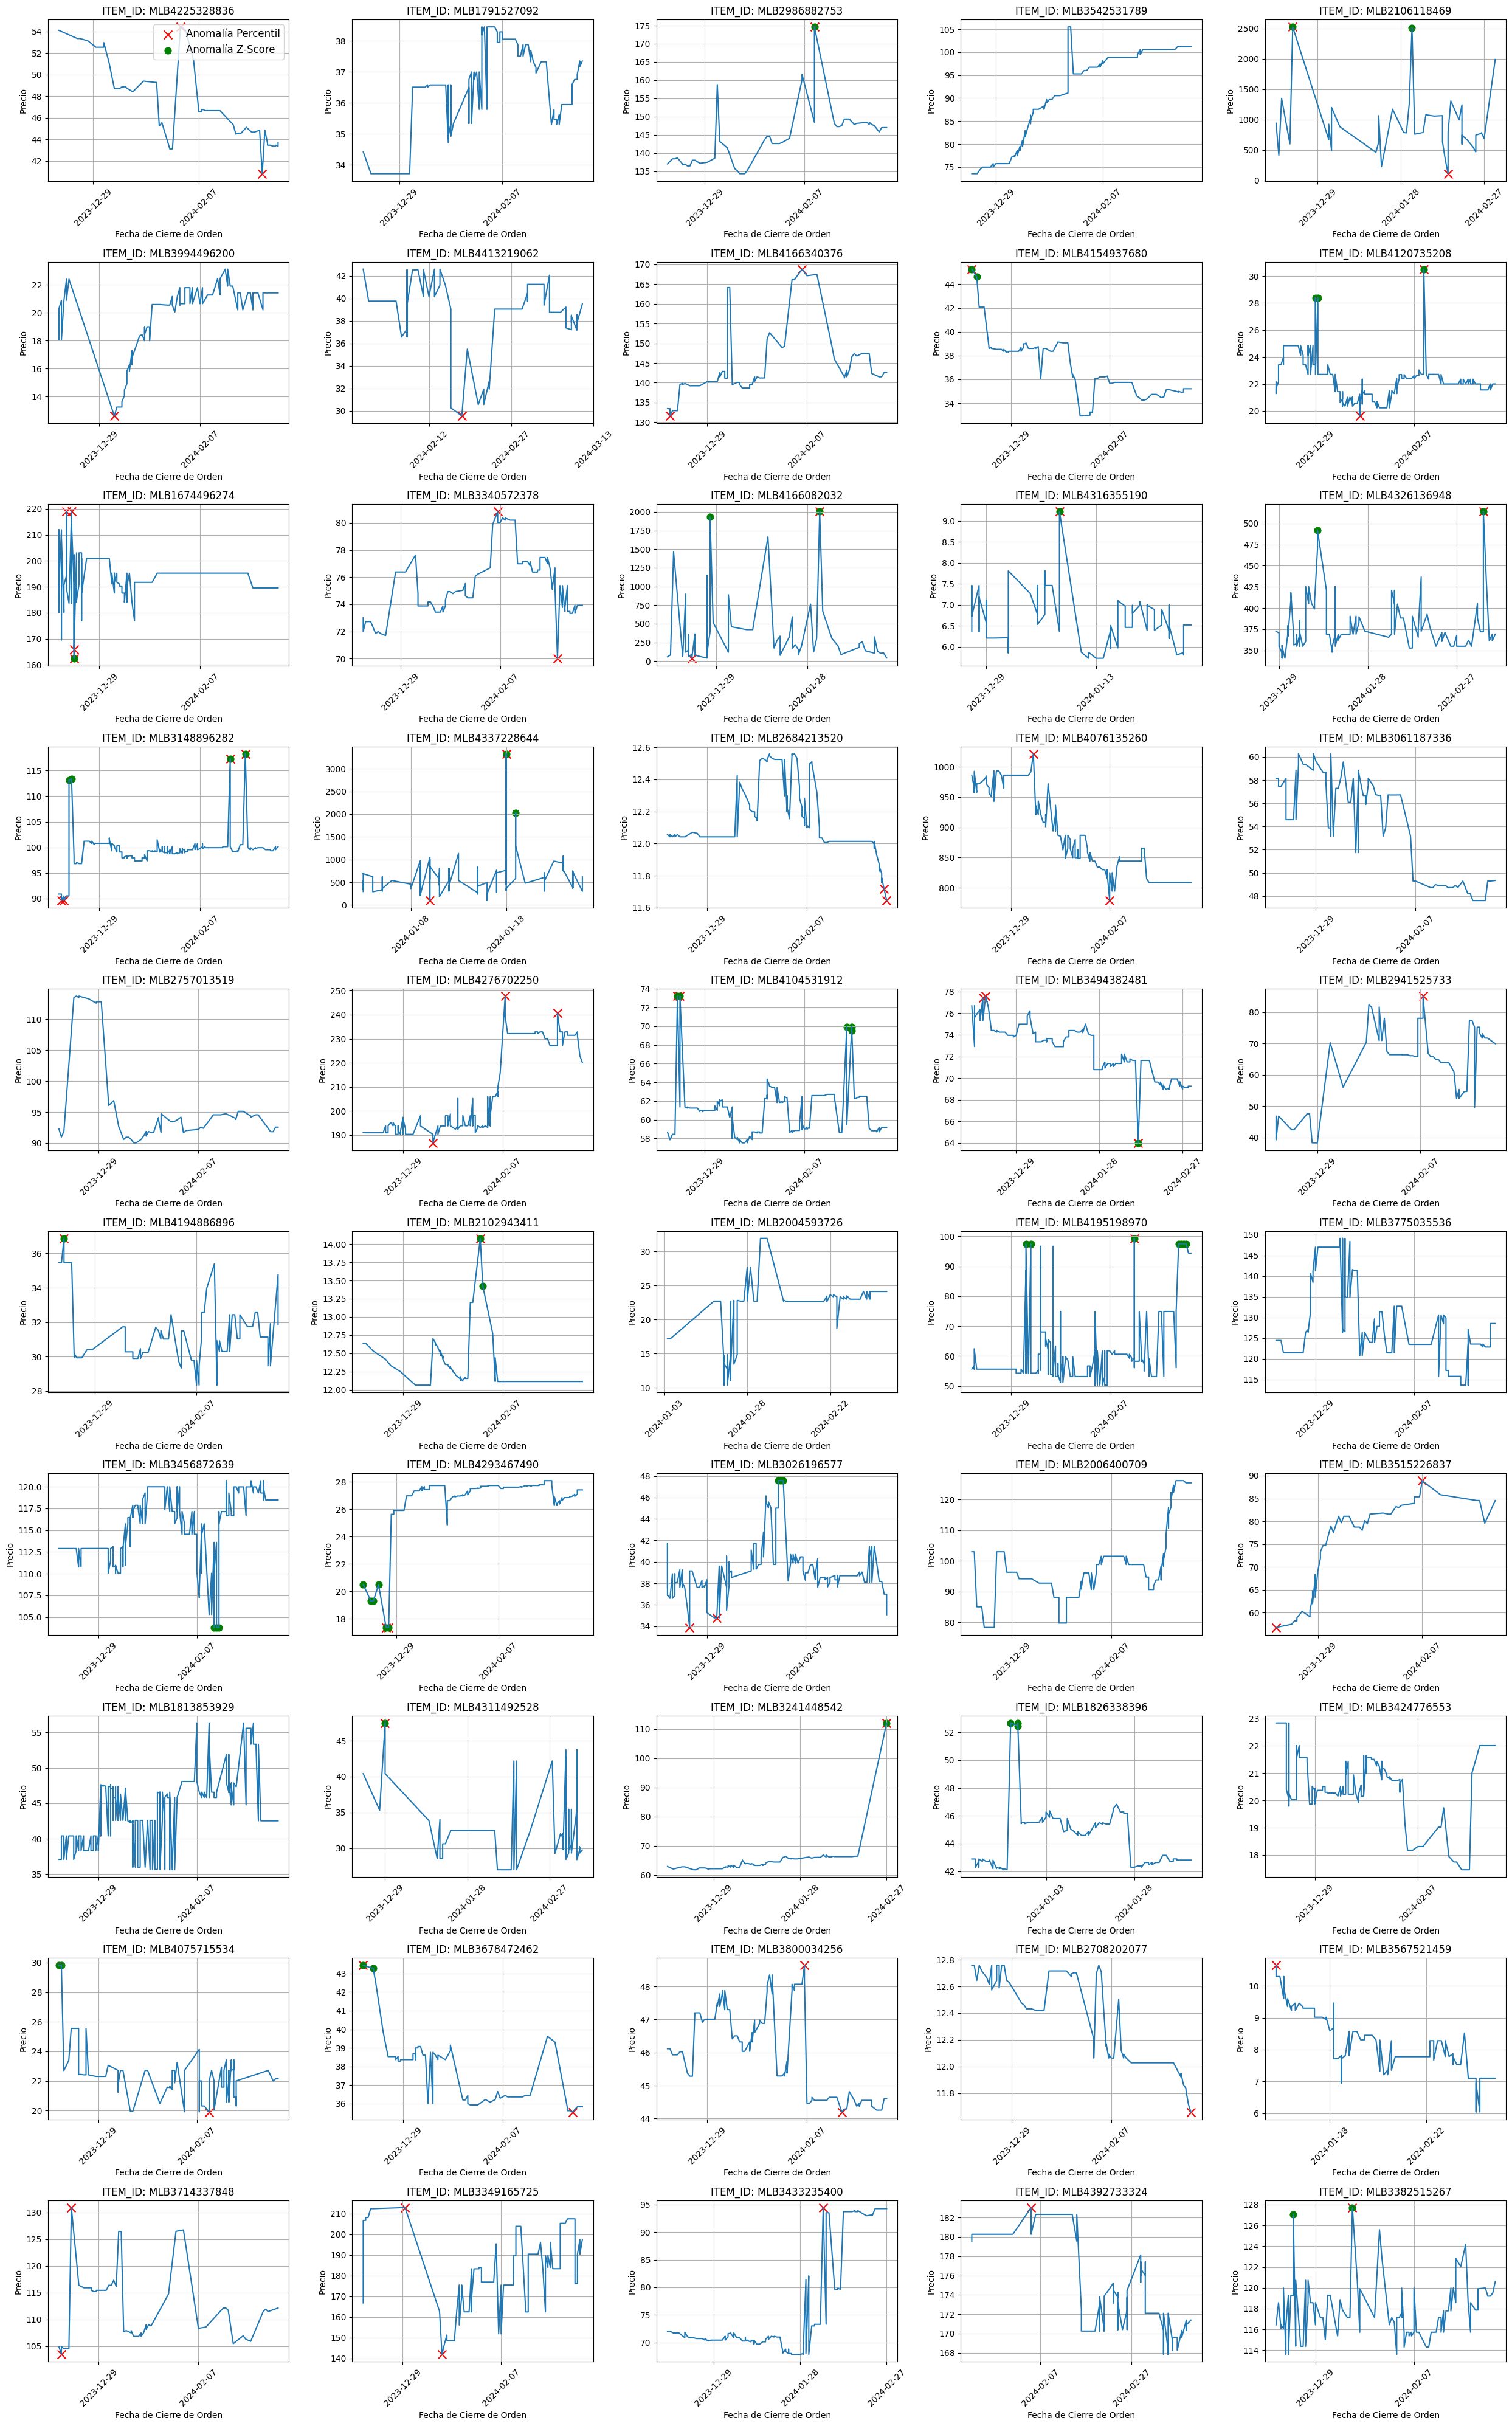

In [303]:
#Seleccionamos 50 items aleatorios y los graficamos
unique_ids = df['ITEM_ID'].dropna().unique()
sampled_item_ids = np.random.choice(unique_ids, size=50, replace=False)
sample_df = df[df['ITEM_ID'].isin(sampled_item_ids)]
sample_df['ORD_CLOSED_DT'] = pd.to_datetime(sample_df['ORD_CLOSED_DT'])
sample_df.sort_values(['ITEM_ID', 'ORD_CLOSED_DT'], inplace=True)

fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(25, 40))
axes = axes.flatten()

for idx, item_id in enumerate(sampled_item_ids):
    subset = sample_df[sample_df['ITEM_ID'] == item_id]
    ax = axes[idx]
    ax.plot(subset['ORD_CLOSED_DT'], subset['PRICE'], marker='', linestyle='-')
    
    # percentiles
    anomalies_percentile = subset[subset['is_anomaly_percentile']]
    sc1 = ax.scatter(anomalies_percentile['ORD_CLOSED_DT'], anomalies_percentile['PRICE'], color='red', label='Anomalía Percentil', marker='x', s=100)

    #Z-score
    anomalies_z = subset[subset['is_anomaly_z']]
    sc2 = ax.scatter(anomalies_z['ORD_CLOSED_DT'], anomalies_z['PRICE'], color='green', label='Anomalía Z-Score', marker='o', s=60)

    ax.set_title(f'ITEM_ID: {item_id}')
    ax.set_xlabel('Fecha de Cierre de Orden')
    ax.set_ylabel('Precio')
    ax.grid(True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis='x', rotation=45)

    if idx == 0:
        ax.legend(handles=[sc1, sc2], loc='upper right',  fontsize='large')

plt.tight_layout()
plt.show()


Para estos casos en particular, Noto un poco mas de sensibilidad en la solucion de percentiles, por lo cual usaremos esa solucion como primer iteracion:

In [295]:
df['lower_bound'] = pd.Series(dtype=float)
df['upper_bound'] = pd.Series(dtype=float)

for item_id, group in df.groupby('ITEM_ID'):
    # Calcular los percentiles 1 y 99 para cada item
    lower_bound = group['PRICE'].quantile(0.01)
    upper_bound = group['PRICE'].quantile(0.99)
    
    # Almacenar los límites en el DataFrame
    df.loc[group.index, 'lower_bound'] = lower_bound
    df.loc[group.index, 'upper_bound'] = upper_bound

df[['ITEM_ID', 'ORD_CLOSED_DT', 'PRICE', 'lower_bound', 'upper_bound']].head()


,ITEM_ID,ORD_CLOSED_DT,PRICE,lower_bound,upper_bound
0,MLB4432316952,2024-02-15,22.0100,16.8057,89.54804
1,MLB4432316952,2024-03-02,19.8090,16.8057,89.54804
2,MLB4432316952,2024-02-16,22.0100,16.8057,89.54804
3,MLB4432316952,2024-03-08,23.8134,16.8057,89.54804
4,MLB4432316952,2024-02-22,19.0990,16.8057,89.54804


# Preparacion de datos para la ingesta

In [297]:
# Agrupamos los datos para tener un row por item

result = df.groupby('ITEM_ID').agg({
    'PRICE': lambda x: sorted(list(x)),
    'lower_bound': 'first',
    'upper_bound': 'first'
}).reset_index()

In [298]:
#Renombramos algunas columnas, ademas usaremos el item_id como indice para MongoDB
rename_dict = {
    'ITEM_ID': '_id',
    'PRICE': 'historical_prices',
}

# Renombrar las columnas
result.rename(columns=rename_dict, inplace=True)


In [299]:
result.head()

,_id,historical_prices,lower_bound,upper_bound
0,MLB1073354076,"[15.62, 113.6, 134.9, 157.62, 166.14, 191.7, 2...",54.812000,3648.548000
1,MLB1439503311,"[32.6316, 32.6955, 32.8233, 32.8943, 34.648, 3...",32.668023,48.412415
2,MLB1450506718,"[78.1, 92.3, 92.3, 99.4, 106.5, 106.5, 110.05,...",87.472000,1548.013000
3,MLB1632127417,"[744.79, 744.79, 744.79, 744.79, 744.79, 756.1...",744.790000,915.190000
4,MLB1636826196,"[426.0, 582.2, 585.75, 710.0, 724.3065, 839.93...",532.216000,2094.500000


In [300]:
#Convertimos los datos a Diccionario de records
records = result.to_dict('records')

In [276]:
# Con fines de muestra vamos solo a guardar 30 items
records_subset = records[:30]

# Guardar los datos en un archivo JSON
with open('item_data.json', 'w') as f:
    json.dump(records_subset, f, indent=4)

In [301]:
records_subset[0]

{'_id': 'MLB1073354076',
 'historical_prices': [15.62,
  113.6,
  134.9,
  157.62,
  166.14,
  191.7,
  244.95,
  269.8,
  281.16,
  357.84,
  374.88,
  378.43,
  397.6,
  426.0,
  461.5,
  480.67,
  497.0,
  531.08,
  533.21,
  558.77,
  606.34,
  623.38,
  795.2,
  836.38,
  891.76,
  898.86,
  979.8,
  989.74,
  1033.76,
  1073.52,
  1086.3,
  1097.66,
  1378.82,
  1390.18,
  1469.7,
  1519.4,
  1571.94,
  2061.84,
  2201.0,
  2861.3,
  4173.38],
 'lower_bound': 54.812,
 'upper_bound': 3648.548000000002}


Este nuevo archivo, **item_data.json**, es un array con todos los ítems y sus respectivas estadísticas. Ciertamente, no ocuparemos la clave 'historical_prices'; bastará con el lower y upper bound, pero igual lo ingestaremos para tener la data más enriquecida.

La forma de ingesta será mediante **mongoimport**, el cual será un comando que se ejecutará como un entrypoint al momento de iniciar el contenedor de Mongo.


# Conclusiones:
Si bien hay mucho por explorar, como métodos más avanzados usando modelos de ML como isolation forest, etc., siempre es bueno pensar en una iteración sencilla para probar y acoplar todos los componentes.

En un futuro podemos pensar en cómo tener un ground truth, de cuáles en verdad son anomalías y así poder medir de manera más precisa qué modelo/algoritmo/estadístico es el mejor para la detección de los mismos.